In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.interpolate import make_interp_spline

In [137]:
train = pd.read_csv('../data/train.csv')
X_test = pd.read_csv('../data/test.csv')
y_train = train['Y']
X_train = train.drop('Y', axis=1)
num_features = X_train.shape[1]
train.head()

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
0,12.083210,16,7,15.9,1,13.6,26,3.6,-20.0,6,2,378,6,7.85,1042.80,6
1,12.433754,19,14,16.4,3,16.7,19,3.5,32.9,0,3,595,11,0.86,83.55,5
2,11.659181,12,14,16.0,2,16.5,17,3.8,45.4,0,2,210,8,1.30,134.29,5
3,15.449989,21,2,16.3,4,9.6,23,3.4,29.0,26,4,1353,10,5.52,736.77,11
4,12.805393,11,11,15.3,2,11.9,22,3.5,35.0,1,3,790,8,1.63,407.42,4


In [138]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=99)

In [139]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

In [140]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())

In [141]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [142]:
EPOCHS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_FEATURES = num_features

In [143]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

In [144]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.layer_2 = nn.Linear(16, 32)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.layer_3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(num_features=16)
        self.layer_out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) 
        
    def forward(self, inputs):
        x = self.relu(self.bn1(self.layer_1(inputs)))
        x = self.dropout(self.relu(self.bn2(self.layer_2(x))))
        x = self.dropout(self.relu(self.bn3(self.layer_3(x))))
        x = self.layer_out(x)
        return (x)


In [145]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=15, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [146]:
loss_stats = {
    'train': [],
    "val": []
}

In [147]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION    
    with torch.no_grad():

        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_epoch_loss += val_loss.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 155.52987 | Val Loss: 167.93300
Epoch 002: | Train Loss: 150.82477 | Val Loss: 163.35802
Epoch 003: | Train Loss: 147.66741 | Val Loss: 158.27068
Epoch 004: | Train Loss: 142.81281 | Val Loss: 152.28959
Epoch 005: | Train Loss: 138.07615 | Val Loss: 148.97431
Epoch 006: | Train Loss: 135.16002 | Val Loss: 145.18856
Epoch 007: | Train Loss: 130.42473 | Val Loss: 141.73486
Epoch 008: | Train Loss: 125.82957 | Val Loss: 138.08636
Epoch 009: | Train Loss: 121.66991 | Val Loss: 135.61195
Epoch 010: | Train Loss: 114.33145 | Val Loss: 130.34998
Epoch 011: | Train Loss: 111.38540 | Val Loss: 125.34685
Epoch 012: | Train Loss: 105.13842 | Val Loss: 119.71052
Epoch 013: | Train Loss: 101.66576 | Val Loss: 113.44499
Epoch 014: | Train Loss: 92.90142 | Val Loss: 107.30802
Epoch 015: | Train Loss: 87.68364 | Val Loss: 101.78427
Epoch 016: | Train Loss: 84.72985 | Val Loss: 97.41163
Epoch 017: | Train Loss: 76.08550 | Val Loss: 89.89308
Epoch 018: | Train Loss: 71.09926 | V

Epoch 151: | Train Loss: 12.57446 | Val Loss: 6.61914
Epoch 152: | Train Loss: 12.15506 | Val Loss: 6.25971
Epoch 153: | Train Loss: 12.46887 | Val Loss: 6.48437
Epoch 154: | Train Loss: 12.81235 | Val Loss: 6.50544
Epoch 155: | Train Loss: 12.90220 | Val Loss: 6.51068
Epoch 156: | Train Loss: 11.29553 | Val Loss: 6.23309
Epoch 157: | Train Loss: 12.62583 | Val Loss: 6.19845
Epoch 158: | Train Loss: 11.04789 | Val Loss: 6.27698
Epoch 159: | Train Loss: 13.92746 | Val Loss: 6.57974
Epoch 160: | Train Loss: 12.32788 | Val Loss: 7.33133
Epoch 161: | Train Loss: 13.24131 | Val Loss: 6.94148
Epoch 162: | Train Loss: 12.26673 | Val Loss: 7.06884
Epoch 163: | Train Loss: 10.95627 | Val Loss: 6.41183
Epoch 164: | Train Loss: 12.57654 | Val Loss: 6.75338
Epoch 165: | Train Loss: 12.28763 | Val Loss: 6.92201
Epoch 166: | Train Loss: 12.09228 | Val Loss: 6.76209
Epoch 167: | Train Loss: 12.10897 | Val Loss: 6.16813
Epoch 168: | Train Loss: 10.89437 | Val Loss: 6.13829
Epoch 169: | Train Loss: 12.

Epoch 305: | Train Loss: 8.34663 | Val Loss: 4.32020
Epoch 306: | Train Loss: 8.17774 | Val Loss: 4.34040
Epoch 307: | Train Loss: 8.32371 | Val Loss: 4.25728
Epoch 308: | Train Loss: 8.37595 | Val Loss: 4.37140
Epoch 309: | Train Loss: 8.76610 | Val Loss: 4.34218
Epoch 310: | Train Loss: 8.96625 | Val Loss: 4.30199
Epoch 311: | Train Loss: 8.79689 | Val Loss: 4.32169
Epoch 312: | Train Loss: 7.65634 | Val Loss: 4.29578
Epoch 313: | Train Loss: 9.45353 | Val Loss: 4.28380
Epoch 314: | Train Loss: 9.16192 | Val Loss: 4.30970
Epoch 315: | Train Loss: 9.19689 | Val Loss: 4.43387
Epoch 316: | Train Loss: 7.88346 | Val Loss: 4.26552
Epoch 317: | Train Loss: 8.70932 | Val Loss: 4.44701
Epoch 318: | Train Loss: 8.26499 | Val Loss: 4.79502
Epoch 319: | Train Loss: 7.94929 | Val Loss: 4.70782
Epoch 320: | Train Loss: 8.17192 | Val Loss: 4.27070
Epoch 321: | Train Loss: 8.88019 | Val Loss: 3.98519
Epoch 322: | Train Loss: 8.02258 | Val Loss: 4.27376
Epoch 323: | Train Loss: 8.02544 | Val Loss: 4

Epoch 461: | Train Loss: 6.45163 | Val Loss: 3.09878
Epoch 462: | Train Loss: 6.08794 | Val Loss: 3.22884
Epoch 463: | Train Loss: 5.13091 | Val Loss: 3.10367
Epoch 464: | Train Loss: 5.63362 | Val Loss: 3.15138
Epoch 465: | Train Loss: 6.01209 | Val Loss: 3.20929
Epoch 466: | Train Loss: 6.38627 | Val Loss: 3.26069
Epoch 467: | Train Loss: 5.89310 | Val Loss: 3.17760
Epoch 468: | Train Loss: 6.29208 | Val Loss: 3.14209
Epoch 469: | Train Loss: 5.78451 | Val Loss: 3.15263
Epoch 470: | Train Loss: 5.67080 | Val Loss: 3.06688
Epoch 471: | Train Loss: 5.37325 | Val Loss: 2.95217
Epoch 472: | Train Loss: 5.08502 | Val Loss: 2.94836
Epoch 473: | Train Loss: 5.12792 | Val Loss: 2.99866
Epoch 474: | Train Loss: 5.41878 | Val Loss: 2.94744
Epoch 475: | Train Loss: 5.42985 | Val Loss: 2.89649
Epoch 476: | Train Loss: 6.01763 | Val Loss: 3.09734
Epoch 477: | Train Loss: 5.04425 | Val Loss: 3.20126
Epoch 478: | Train Loss: 5.47403 | Val Loss: 3.18767
Epoch 479: | Train Loss: 5.18728 | Val Loss: 3

Epoch 617: | Train Loss: 3.48907 | Val Loss: 2.68262
Epoch 618: | Train Loss: 3.59065 | Val Loss: 2.69841
Epoch 619: | Train Loss: 3.83031 | Val Loss: 2.60383
Epoch 620: | Train Loss: 3.97679 | Val Loss: 2.55903
Epoch 621: | Train Loss: 3.87759 | Val Loss: 2.60289
Epoch 622: | Train Loss: 4.04562 | Val Loss: 2.63142
Epoch 623: | Train Loss: 3.97068 | Val Loss: 2.59033
Epoch 624: | Train Loss: 3.52387 | Val Loss: 2.55231
Epoch 625: | Train Loss: 3.75631 | Val Loss: 2.58747
Epoch 626: | Train Loss: 4.01043 | Val Loss: 2.64309
Epoch 627: | Train Loss: 3.88258 | Val Loss: 2.64029
Epoch 628: | Train Loss: 3.68817 | Val Loss: 2.66644
Epoch 629: | Train Loss: 4.05332 | Val Loss: 2.61447
Epoch 630: | Train Loss: 3.92662 | Val Loss: 2.61560
Epoch 631: | Train Loss: 3.68989 | Val Loss: 2.61001
Epoch 632: | Train Loss: 3.99730 | Val Loss: 2.63671
Epoch 633: | Train Loss: 4.11852 | Val Loss: 2.58170
Epoch 634: | Train Loss: 3.65470 | Val Loss: 2.49159
Epoch 635: | Train Loss: 4.00923 | Val Loss: 2

Epoch 773: | Train Loss: 2.62608 | Val Loss: 2.34274
Epoch 774: | Train Loss: 2.54998 | Val Loss: 2.33121
Epoch 775: | Train Loss: 2.39919 | Val Loss: 2.33319
Epoch 776: | Train Loss: 2.69640 | Val Loss: 2.39788
Epoch 777: | Train Loss: 2.68969 | Val Loss: 2.40154
Epoch 778: | Train Loss: 2.70303 | Val Loss: 2.40551
Epoch 779: | Train Loss: 2.70199 | Val Loss: 2.41223
Epoch 780: | Train Loss: 2.62269 | Val Loss: 2.42107
Epoch 781: | Train Loss: 2.61702 | Val Loss: 2.38005
Epoch 782: | Train Loss: 2.81008 | Val Loss: 2.34407
Epoch 783: | Train Loss: 2.82036 | Val Loss: 2.43843
Epoch 784: | Train Loss: 2.66322 | Val Loss: 2.39338
Epoch 785: | Train Loss: 2.76338 | Val Loss: 2.43163
Epoch 786: | Train Loss: 2.51713 | Val Loss: 2.44642
Epoch 787: | Train Loss: 2.56441 | Val Loss: 2.42265
Epoch 788: | Train Loss: 2.80425 | Val Loss: 2.44363
Epoch 789: | Train Loss: 2.48501 | Val Loss: 2.44297
Epoch 790: | Train Loss: 2.71374 | Val Loss: 2.45299
Epoch 791: | Train Loss: 2.71559 | Val Loss: 2

Epoch 928: | Train Loss: 1.98324 | Val Loss: 2.35724
Epoch 929: | Train Loss: 2.04142 | Val Loss: 2.31201
Epoch 930: | Train Loss: 2.06019 | Val Loss: 2.35953
Epoch 931: | Train Loss: 2.08983 | Val Loss: 2.37578
Epoch 932: | Train Loss: 1.98327 | Val Loss: 2.36818
Epoch 933: | Train Loss: 1.97655 | Val Loss: 2.36615
Epoch 934: | Train Loss: 1.97380 | Val Loss: 2.35865
Epoch 935: | Train Loss: 1.94781 | Val Loss: 2.34101
Epoch 936: | Train Loss: 2.02592 | Val Loss: 2.35129
Epoch 937: | Train Loss: 2.05869 | Val Loss: 2.38908
Epoch 938: | Train Loss: 1.97418 | Val Loss: 2.39672
Epoch 939: | Train Loss: 1.95540 | Val Loss: 2.41741
Epoch 940: | Train Loss: 1.94055 | Val Loss: 2.42954
Epoch 941: | Train Loss: 1.99448 | Val Loss: 2.44646
Epoch 942: | Train Loss: 1.99833 | Val Loss: 2.45754
Epoch 943: | Train Loss: 2.02887 | Val Loss: 2.43116
Epoch 944: | Train Loss: 1.91674 | Val Loss: 2.40693
Epoch 945: | Train Loss: 2.03695 | Val Loss: 2.38201
Epoch 946: | Train Loss: 1.96497 | Val Loss: 2

(0.0, 30.0)

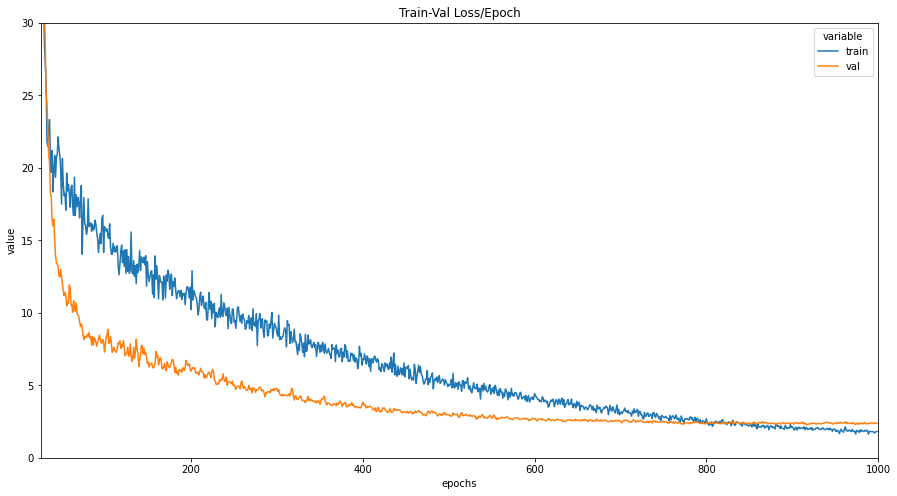

In [148]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')
plt.xlim([25, EPOCHS])
plt.ylim([0, 30])
